/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_13481/2165447655.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  train_prices = yf.download(downloadable_tickers, start=train_start, end=train_end)["Close"].dropna()
[*********************100%***********************]  11 of 11 completed
/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_13481/2165447655.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  test_prices = yf.download(downloadable_tickers, start=test_start, end=test_end)["Close"].dropna()
[*********************100%***********************]  11 of 11 completed


Processing pair: VO & IWB
Processing pair: VO & SCHB
Processing pair: VO & SPY
Processing pair: VO & SCHX
Processing pair: VO & VOO
Processing pair: DVY & IWR
Processing pair: IWR & DIA
Processing pair: DVY & OEF
Processing pair: DVY & VYM
Processing pair: VO & IWB
Processing pair: VO & SCHB
Processing pair: VO & SPY
Processing pair: VO & SCHX
Processing pair: VO & VOO
Processing pair: DVY & IWR
Processing pair: IWR & DIA
Processing pair: DVY & OEF
Processing pair: DVY & VYM
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.7s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.8s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.8s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_

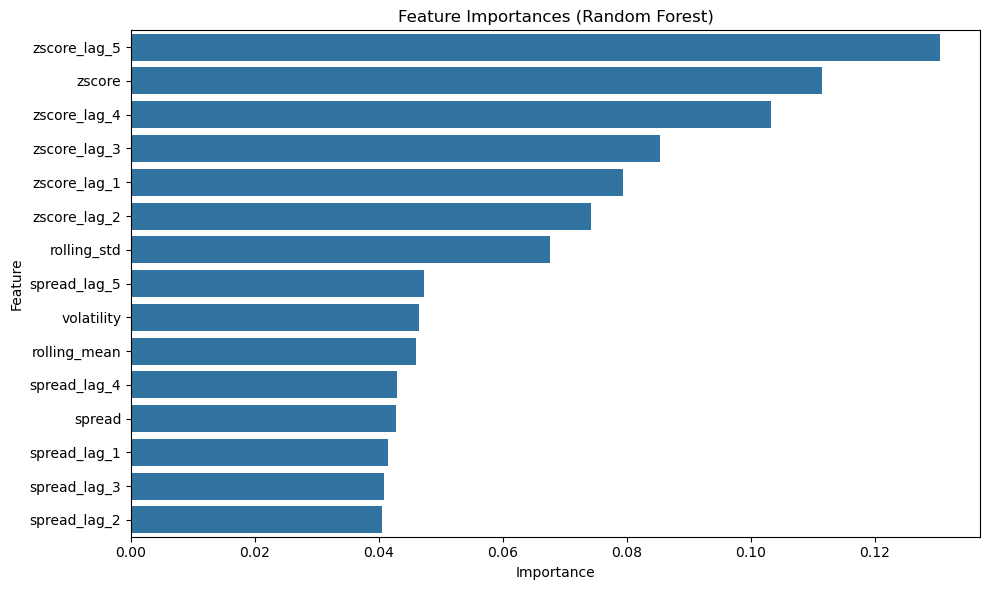

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Define ETF pairs and date ranges
# -----------------------------
etf_pairs = [('VO','IWB'), ('VO','SCHB'), ('VO','SPY'), ('VO','SCHX'), ('VO','VOO'), ('DVY','IWR'), ('IWR','DIA'), ('DVY','OEF'), ('DVY','VYM')]
downloadable_tickers = list(set([etf for pair in etf_pairs for etf in pair]))

train_start = "2015-01-01"
train_end = "2020-01-01"
test_start = "2020-01-02"
test_end = "2024-12-31"

# -----------------------------
# 2. Download training and testing data
# -----------------------------
train_prices = yf.download(downloadable_tickers, start=train_start, end=train_end)["Close"].dropna()
test_prices = yf.download(downloadable_tickers, start=test_start, end=test_end)["Close"].dropna()

# -----------------------------
# 3. Function to process a pair
# -----------------------------
def process_pair(etf1, etf2, price_data, lookback=60):
    df = pd.DataFrame(index=price_data.index)
    df["etf1"] = price_data[etf1]
    df["etf2"] = price_data[etf2]

    # Hedge ratio
    df["hedge_ratio"] = (
        df["etf1"].rolling(lookback).cov(df["etf2"]) /
        df["etf2"].rolling(lookback).var()
    )

    # Spread and z-score
    df["spread"] = df["etf1"] - df["hedge_ratio"] * df["etf2"]
    spread_mean = df["spread"].rolling(lookback).mean()
    spread_std = df["spread"].rolling(lookback).std()
    df["zscore"] = (df["spread"] - spread_mean) / spread_std

    # NEW FEATURES: rolling mean, rolling std, volatility
    df["rolling_mean"] = spread_mean
    df["rolling_std"] = spread_std
    df["volatility"] = df["spread"].pct_change().rolling(lookback).std()

    # Lag features
    for i in range(1, 6):
        df[f"spread_lag_{i}"] = df["spread"].shift(i)
        df[f"zscore_lag_{i}"] = df["zscore"].shift(i)

    # Target = mean reversion
    df["target"] = (
        (df["zscore"].shift(-1).abs() < df["zscore"].abs()).astype(int)
    )
    df["pair"] = f"{etf1}_{etf2}"

    return df.dropna()

# -----------------------------
# 4. Process all pairs
# -----------------------------
def process_all_pairs(pairs, price_data):
    processed = []
    for etf1, etf2 in pairs:
        print(f"Processing pair: {etf1} & {etf2}")
        processed.append(process_pair(etf1, etf2, price_data))
    return pd.concat(processed)

train_df = process_all_pairs(etf_pairs, train_prices)
test_df = process_all_pairs(etf_pairs, test_prices)

# -----------------------------
# 5. Feature columns (NEW FEATURES ADDED)
# -----------------------------
feature_cols = [
    'spread', 'zscore',
    'rolling_mean', 'rolling_std', 'volatility',
    'spread_lag_1', 'zscore_lag_1',
    'spread_lag_2', 'zscore_lag_2',
    'spread_lag_3', 'zscore_lag_3',
    'spread_lag_4', 'zscore_lag_4',
    'spread_lag_5', 'zscore_lag_5'
]

X_train, y_train = train_df[feature_cols], train_df["target"]
X_test, y_test = test_df[feature_cols], test_df["target"]

# -----------------------------
# 6. Train Random Forest with Grid Search
# -----------------------------
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
print("\nBest Parameters:", grid_search.best_params_)

# -----------------------------
# 7. Evaluate ONLY on Test Set
# -----------------------------
y_pred = best_rf.predict(X_test)

print("\nClassification Report (Test Data):\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("True Label Distribution:", Counter(y_test))
print("Predicted Label Distribution:", Counter(y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# -----------------------------
# 8. Feature Importance
# -----------------------------
importances = best_rf.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature')
plt.title('Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()


In [2]:
test_df.info(
)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10206 entries, 2020-06-29 to 2024-12-30
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   etf1          10206 non-null  float64
 1   etf2          10206 non-null  float64
 2   hedge_ratio   10206 non-null  float64
 3   spread        10206 non-null  float64
 4   zscore        10206 non-null  float64
 5   rolling_mean  10206 non-null  float64
 6   rolling_std   10206 non-null  float64
 7   volatility    10206 non-null  float64
 8   spread_lag_1  10206 non-null  float64
 9   zscore_lag_1  10206 non-null  float64
 10  spread_lag_2  10206 non-null  float64
 11  zscore_lag_2  10206 non-null  float64
 12  spread_lag_3  10206 non-null  float64
 13  zscore_lag_3  10206 non-null  float64
 14  spread_lag_4  10206 non-null  float64
 15  zscore_lag_4  10206 non-null  float64
 16  spread_lag_5  10206 non-null  float64
 17  zscore_lag_5  10206 non-null  float64
 18  target   

In [3]:
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter

print("\n📊 Classification Report (Test Data Only):\n", classification_report(y_test, y_pred))
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("🔹 True Label Distribution (Test):", Counter(y_test))
print("🔹 Predicted Label Distribution (Test):", Counter(y_pred))



📊 Classification Report (Test Data Only):
               precision    recall  f1-score   support

           0       0.75      0.62      0.68      4142
           1       0.77      0.86      0.81      6064

    accuracy                           0.76     10206
   macro avg       0.76      0.74      0.74     10206
weighted avg       0.76      0.76      0.76     10206

✅ Accuracy: 0.7621
🔹 True Label Distribution (Test): Counter({1: 6064, 0: 4142})
🔹 Predicted Label Distribution (Test): Counter({np.int64(1): 6804, np.int64(0): 3402})


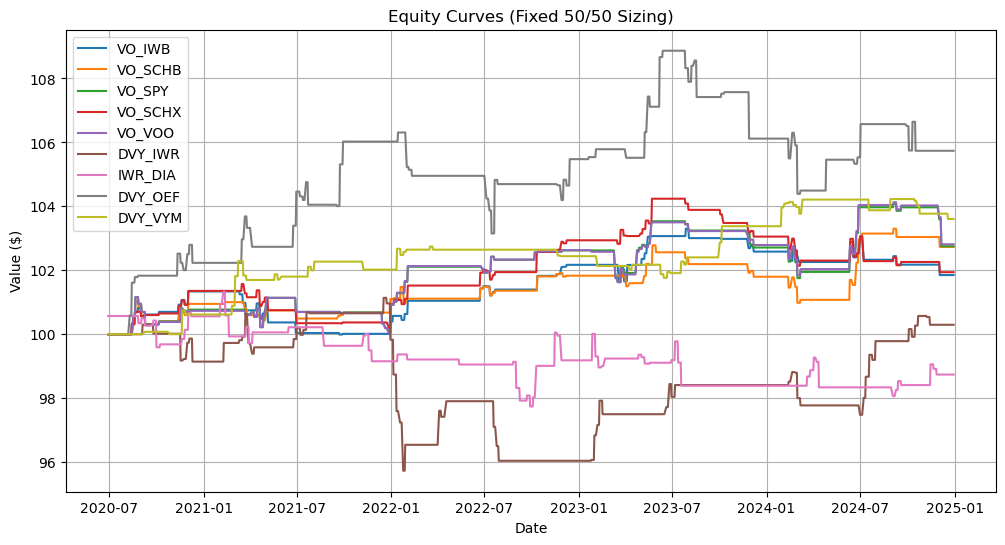

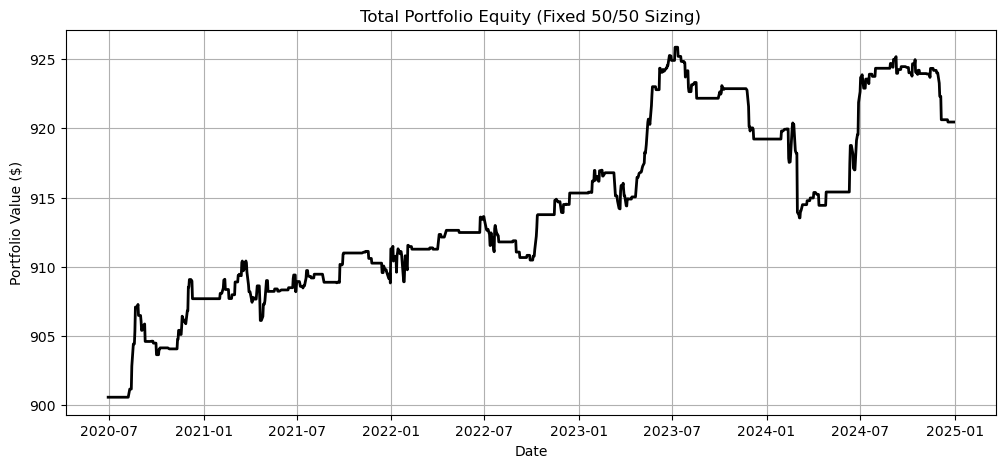


📊 Summary (Fixed 50/50 Sizing)
VO_IWB: Final Value = $101.85, Total Return = 1.85%, Trades = 63
VO_SCHB: Final Value = $102.73, Total Return = 2.73%, Trades = 64
VO_SPY: Final Value = $102.75, Total Return = 2.75%, Trades = 66
VO_SCHX: Final Value = $101.94, Total Return = 1.94%, Trades = 68
VO_VOO: Final Value = $102.81, Total Return = 2.81%, Trades = 67
DVY_IWR: Final Value = $100.29, Total Return = 0.29%, Trades = 60
IWR_DIA: Final Value = $98.74, Total Return = -1.82%, Trades = 66
DVY_OEF: Final Value = $105.74, Total Return = 5.74%, Trades = 66
DVY_VYM: Final Value = $103.60, Total Return = 3.60%, Trades = 52

💼 Total Portfolio Performance
Initial Portfolio Value: $900.57
Final Portfolio Value:   $920.46
Total Return:            2.21%


In [4]:
# =========================================================
# Mock portfolio with fixed 50/50 position sizing
# =========================================================

test_df = test_df.copy()

# Add back binary prediction for trade signals
test_df["prediction"] = best_rf.predict(test_df[feature_cols])


def simulate_pair_fixed_sizing(
    pair_df, 
    initial_cash_per_pair=100.0, 
    holding_period=3, 
    entry_threshold=1.8, 
    use_compounding=True
):
    """
    Trading rule:
    - Enter only when prediction == 1 and |zscore| >= entry_threshold
    - Trade size is fixed 50/50 of cash (not scaled by probability)
    """
    df = pair_df.sort_index().copy()
    pair_name = df["pair"].iloc[0]
    cash = float(initial_cash_per_pair)

    equity = pd.Series(index=df.index, dtype=float)
    equity.iloc[0] = initial_cash_per_pair
    equity.iloc[:] = np.nan
    equity.iloc[0] = initial_cash_per_pair

    trades = []
    i = 0
    n = len(df)

    while i < n - holding_period:
        row = df.iloc[i]
        prediction = row["prediction"]

        if (prediction == 1) and (abs(row["zscore"]) >= entry_threshold):
            entry_idx = i
            exit_idx = i + holding_period
            entry_date = df.index[entry_idx]
            exit_date = df.index[exit_idx]

            price1_in, price2_in = row["etf1"], row["etf2"]
            price1_out, price2_out = df.iloc[exit_idx]["etf1"], df.iloc[exit_idx]["etf2"]

            # Fixed notional regardless of probability
            notional = (cash if use_compounding else initial_cash_per_pair)
            long_dollars, short_dollars = notional / 2.0, notional / 2.0

            if row["zscore"] > 0:
                # Short ETF1, Long ETF2
                shares_short1 = short_dollars / price1_in
                shares_long2  = long_dollars / price2_in
                pnl = (shares_long2 * (price2_out - price2_in)) + (shares_short1 * (price1_in - price1_out))
                direction = "Short ETF1 / Long ETF2"
            else:
                # Long ETF1, Short ETF2
                shares_long1  = long_dollars / price1_in
                shares_short2 = short_dollars / price2_in
                pnl = (shares_long1 * (price1_out - price1_in)) + (shares_short2 * (price2_in - price2_out))
                direction = "Long ETF1 / Short ETF2"

            cash += pnl
            equity.loc[entry_date:exit_date] = cash

            trades.append({
                "pair": pair_name,
                "entry_date": entry_date,
                "exit_date": exit_date,
                "direction": direction,
                "pnl": float(pnl),
                "notional": float(notional)
            })

            i = exit_idx + 1
        else:
            equity.iloc[i] = cash
            i += 1

    equity.ffill(inplace=True)
    return equity, trades


# -----------------------------
# Run simulation for all pairs
# -----------------------------
pair_results = []
initial_cash_per_pair = 100.0

for pair_name in test_df["pair"].unique():
    pair_df = test_df[test_df["pair"] == pair_name]
    equity, trades = simulate_pair_fixed_sizing(pair_df, initial_cash_per_pair=initial_cash_per_pair)

    pair_results.append({
        "pair": pair_name,
        "equity": equity,
        "trades": trades,
        "final_value": equity.iloc[-1],
        "total_return": (equity.iloc[-1] / equity.iloc[0] - 1) * 100,
        "n_trades": len(trades)
    })


# -----------------------------
# Plot equity curves per pair and total
# -----------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
combined_equity = 0

for result in pair_results:
    plt.plot(result["equity"].index, result["equity"].values, label=result["pair"])
    if isinstance(combined_equity, int):
        combined_equity = result["equity"]
    else:
        combined_equity = combined_equity.add(result["equity"], fill_value=0)

plt.title("Equity Curves (Fixed 50/50 Sizing)")
plt.xlabel("Date")
plt.ylabel("Value ($)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(combined_equity.index, combined_equity.values, color="black", lw=2)
plt.title("Total Portfolio Equity (Fixed 50/50 Sizing)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.show()


# -----------------------------
# Print summary metrics
# -----------------------------
print("\n📊 Summary (Fixed 50/50 Sizing)")
for result in pair_results:
    print(f"{result['pair']}: Final Value = ${result['final_value']:.2f}, "
          f"Total Return = {result['total_return']:.2f}%, Trades = {result['n_trades']}")


# -----------------------------
# Show total portfolio return
# -----------------------------
initial_total_value = combined_equity.iloc[0]
final_total_value = combined_equity.iloc[-1]
total_return_pct = (final_total_value - initial_total_value) / initial_total_value * 100

print("\n💼 Total Portfolio Performance")
print(f"Initial Portfolio Value: ${initial_total_value:,.2f}")
print(f"Final Portfolio Value:   ${final_total_value:,.2f}")
print(f"Total Return:            {total_return_pct:.2f}%")

combined_equity.to_csv("rf_equity.csv", header=["Portfolio Value"])


In [5]:
# -----------------------------
# Calculate Sharpe Ratios
# -----------------------------
def compute_sharpe_ratio(equity_series):
    daily_returns = equity_series.pct_change().dropna()
    mean_return = daily_returns.mean()
    std_return = daily_returns.std()
    sharpe = (mean_return / std_return) * np.sqrt(252) if std_return > 0 else np.nan
    return sharpe

print("\n📈 Sharpe Ratios (Probability-Based Sizing)")
for result in pair_results:
    sharpe = compute_sharpe_ratio(result["equity"])
    result["sharpe"] = sharpe
    print(f"{result['pair']}: Sharpe Ratio = {sharpe:.2f}")

# Total portfolio Sharpe
portfolio_sharpe = compute_sharpe_ratio(combined_equity)
print(f"\n💼 Total Portfolio Sharpe Ratio: {portfolio_sharpe:.2f}")



📈 Sharpe Ratios (Probability-Based Sizing)
VO_IWB: Sharpe Ratio = 0.38
VO_SCHB: Sharpe Ratio = 0.55
VO_SPY: Sharpe Ratio = 0.43
VO_SCHX: Sharpe Ratio = 0.37
VO_VOO: Sharpe Ratio = 0.44
DVY_IWR: Sharpe Ratio = 0.04
IWR_DIA: Sharpe Ratio = -0.24
DVY_OEF: Sharpe Ratio = 0.50
DVY_VYM: Sharpe Ratio = 0.79

💼 Total Portfolio Sharpe Ratio: 0.72


In [6]:
# -----------------------------
# Compute and Print Max Drawdown
# -----------------------------
def compute_max_drawdown(equity_curve):
    cumulative_max = equity_curve.cummax()
    drawdown = (equity_curve - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()
    print(f"\n📉 Max Drawdown: {max_drawdown:.2%}")
    return max_drawdown

# Apply to combined equity curve
max_drawdown = compute_max_drawdown(combined_equity)



📉 Max Drawdown: -1.33%


Exception ignored in: <function ResourceTracker.__del__ at 0x107a95a80>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/rise-project/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/anaconda3/envs/rise-project/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/anaconda3/envs/rise-project/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10d861a80>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/rise-project/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/anaconda3/envs/rise-project/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/anaconda3/envs/rise-project/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child proces